# STFT, ISTFT, and Griffin-Lim speech vocoder

In this MP, you'll learn to

1. Implement STFT using numpy
2. Implement ISTFT using numpy
3. Implement a Griffin-lim Vocoder, which can reconstruct the waveforms when the phase information is missing
4. Time-stretch or time-shrink the spectrogram before applying Griffin-lim to adjust the speed of the signal

In order to make sure everything works, you might want to go to the command line, and run

    pip install -r requirements.txt
    
This will install the modules that are used on the autograder, including numpy, h5py, and the gradescope utilities.

In [1]:
pip install -r requirements.txt

Below is the functions used for visualization purpose only.

In [2]:
# This function is using librosa for display purpose only, 
# you should not import librosa or use it in submitted.py as this will break the autograder

import librosa
import librosa.display
import numpy as np

def display_spectrogram(spec, sr):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4),sharex=True)
    dB = librosa.amplitude_to_db(np.abs(spec.T), ref=np.max)
    librosa.display.specshow(dB, y_axis='linear', x_axis='time',sr=sr, ax=ax)
    ax.set(title='spectrogram')
    ax.label_outer()

def display_waveform(waveform):
    
    fig, ax = plt.subplots(1,1,figsize=(14,2))
    timestamp = np.arange(len(waveform))/samplerate
    ax.plot(timestamp,waveform)

---------------------------------------------------------------------
## Part 1: STFT

Let's load in a audio file for testing and visualize it in the time domain.

In [3]:
import IPython.display
import matplotlib.pyplot as plt
import importlib, submitted
import soundfile as sf

data, samplerate = sf.read('visible.wav')
print(data.shape)
IPython.display.Audio(data, rate=samplerate)

(320026,)


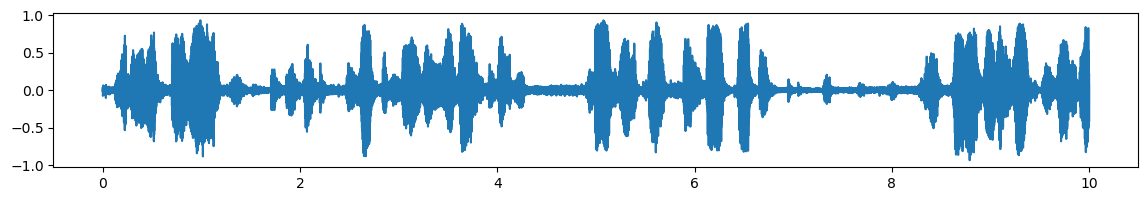

In [4]:
display_waveform(data)

In this part, you will complete the function `stft` in `submitted.py`. Note that you are only allowed to use the `numpy` library to complete the function. You might find `np.fft.fft`, `np.fft.rfft`, `np.hanning` useful. You are welcomed to read the stft implementation from other packages, such as `librosa` or `scipy`, but you should not copy it. To avoid dimension error when we grade your work, we explicitly ask you to implement output dimension of the stft matrix as `((sig_len - window_size) // hop_size + 1), (window_size // 2 + 1)`. 

The high-level idea of implementing a STFT is that you should multiply the hanning window by each window, and then compute the FFT of each of them. Each window is of length `window_length` and apart from each other by `hop_size` samples. Note that we are requiring you to output the non-negative frequency terms of the stft matrix, so if you are using `np.fft.fft`, you should discard half of the values.

In [5]:
importlib.reload(submitted)
help(submitted.stft)

Help on function stft in module submitted:

stft(signal, window_size=2048, hop_size=512)



The shape of the spectrogram is (622, 1025)


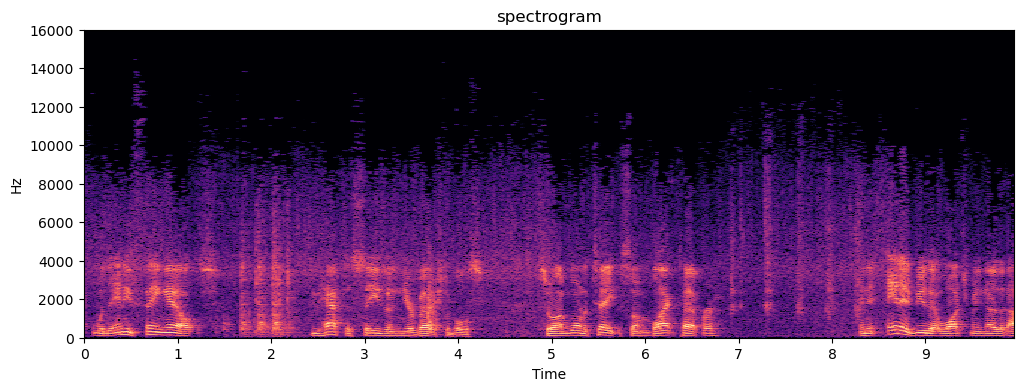

In [6]:
spec = submitted.stft(data)
print('The shape of the spectrogram is', spec.shape)
display_spectrogram(spec, samplerate)

---------------------------------------------------------------------
## Part 2: ISTFT

In this part, you will complete the function `istft` in `submitted.py`. Note that you are only allowed to use the `numpy` library to complete the function. You might find `np.fft.ifft`, `np.fft.irfft` useful. You are welcomed to read the istft implementation from other packages, such as `librosa` or `scipy`, but you should not copy it. To avoid dimension error when we grade your work, we explicitly ask you to implement the output dimension of the reconstructed signal to be `(num_windows - 1) * hop_size + window_size`. 

The high-level idea of implementing a ISTFT is that you should calculate the IFFT of each window in the frequency doamin, and add the reconstructed time-domain signal to the corresponding window in the time doamin. 

In [7]:
importlib.reload(submitted)
help(submitted.istft)

Help on function istft in module submitted:

istft(stft_matrix, hop_size=512)



In [8]:
istft_sig = submitted.istft(spec, 512)
print('The shape of the reconstructed signal is', istft_sig.shape)

The shape of the reconstructed signal is (320000,)


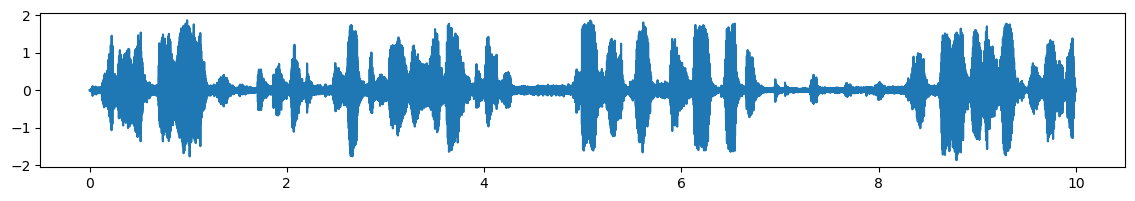

In [9]:
display_waveform(istft_sig)

In [10]:
IPython.display.Audio(istft_sig, rate=samplerate)

---------------------------------------------------------------------
## Part 3: Griffin-Lim Vocoder

When you have the complete complex spectrogram, you use istft to convert the signal back to time domain. What if the phase information is missing and you only have the magnitude spectrogram?

In this part you are going to implement the Griffin-Lim Vocoder, which is an well-known algorithm to reconstruct waveforms when only the magnitude spectrogram is available. 
The high-level steps of Griffin Lim are:
1. Randomly initialize the phase of the spectrogram(Since it's missing from the start)
2. Apply ISTFT to the complex spectrogram consisted of random phase and the known magnitude, get the initial time-domain estimation.
3. Apply STFT to the time-domain estimation to get estimated phase and estimated magnitude. 
4. Discard the estimated magnitude and replace it with the known ground-truth magnitude, and apply ISTFT to the complex spectrogram consisted of estimated phase and ground-truth magnitude to get next-round time estimation.
5. Repeat step 3-4 until convergence.

In [11]:
importlib.reload(submitted)
help(submitted.griffin_lim)

Help on function griffin_lim in module submitted:

griffin_lim(magnitude_spectrogram, phase=None, n_iter=100, window_size=2048, hop_size=512)



Griffin-Lim is a iterative algorithm which refines the phase information gradually. Try to listen to the reconstructed audio at different iterations. Initially the reconstructed audio will have a lot of artifacts since the phase information is completely random, but the artifacts will be alleviated through the number of iterations increases.

In [12]:
reconstructed_iter1 = submitted.griffin_lim(np.abs(spec), n_iter=1)
print('Reconstructed signal has a shape of', reconstructed_iter1.shape)
IPython.display.Audio(reconstructed_iter1, rate=samplerate)

(622, 1025)
(622, 1025)
(622, 1025)
Reconstructed signal has a shape of (320000,)


In [13]:
reconstructed_iter10 = submitted.griffin_lim(np.abs(spec), n_iter=10)
print('Reconstructed signal has a shape of', reconstructed_iter10.shape)
IPython.display.Audio(reconstructed_iter10, rate=samplerate)

(622, 1025)
(622, 1025)
(622, 1025)
Reconstructed signal has a shape of (320000,)


In [14]:
reconstructed_iter100 = submitted.griffin_lim(np.abs(spec), n_iter=100)
print('Reconstructed signal has a shape of', reconstructed_iter100.shape)
IPython.display.Audio(reconstructed_iter100, rate=samplerate)

(622, 1025)
(622, 1025)
(622, 1025)
Reconstructed signal has a shape of (320000,)


You can change the speed of the audio signal by time-stretching or time-shrinking your spectrogram before you applying the Griffin-Lim. In this part, you should complete the function time-stretch Griffin-Lim in the file `submitted.py`. 

You just need to interpolate existing frames to form a new spectrogram before feeding it to the griffin-lim algorithm. You would want the new spectrogram having shape `(int(stretch_factor * num_frames), num_freq_bins)`. You might find the function `np.interp` helpful for interpolating frames. Specifically, the nth frame in the stretched spectrogram will be mapped to the `n / stretch_factor`th frame of the original frame, note that `n / stretch_factor` might not be an int, and `np.interp` will take care of the interpolation for you for non-int index. (e.g. if the stretch factor is 2, the 3rd frame of the stretched spectrogram will be mapped to the 1.5th of the original spectrogram)

In [15]:
importlib.reload(submitted)
help(submitted.time_stretch_griffin_lim)

Help on function time_stretch_griffin_lim in module submitted:

time_stretch_griffin_lim(magnitude_spectrogram, stretch_factor, phase=None, n_iter=100, window_size=2048, hop_size=512)



In [16]:
reconstructed_stretch = submitted.time_stretch_griffin_lim(np.abs(spec), stretch_factor=2, n_iter=100)
print('Reconstructed signal has a shape of', reconstructed_stretch.shape)
IPython.display.Audio(reconstructed_stretch, rate=samplerate)

(1244, 1025)
(1244, 1025)
(1244, 1025)
Reconstructed signal has a shape of (638464,)


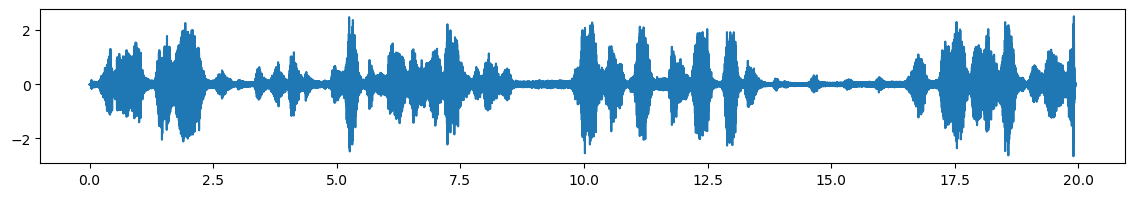

In [17]:
display_waveform(reconstructed_stretch)

In [18]:
reconstructed_shrink = submitted.time_stretch_griffin_lim(np.abs(spec), stretch_factor=0.5, n_iter=100)
print('Reconstructed signal has a shape of', reconstructed_shrink.shape)
IPython.display.Audio(reconstructed_shrink, rate=samplerate)

(311, 1025)
(311, 1025)
(311, 1025)
Reconstructed signal has a shape of (160768,)


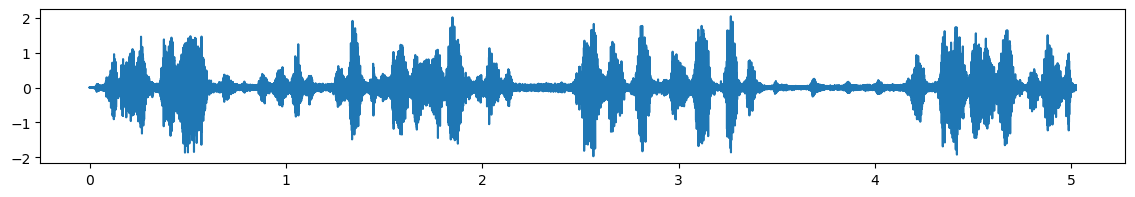

In [19]:
display_waveform(reconstructed_shrink)

-----------------------------------------------------
## Part 4: Vocal Tract Length Normalization

In the Previous part, you stretch the time dimension of the spectrogram to control the speed of the audio. What happens if you stretch the frequency dimension instead? In this part, you should complete the function `freq_stretch_griffin_lim` in the file `submitted.py`. 

Stretching the frequency axis of the spectrogram is also known as vocal tract length normalization, a method to account for the variances in the size of vocal tract for different people. Just by stretching the frequency axis, basic voice conversion can be done by manipulating the fundamental frequency of the speech signal.

Similar to the previous part, you just need to interpolate along the frequency axis instead of the time axis to form a new spectrogram before feeding it to the griffin-lim algorithm. Note that You would not want to change the dimension of the spectrogram (The new spectrogram should still be of the same shape as the original spectrogram). Please crop the or pad the resulting spectrogram to get the appropriate size. You might find the function `np.interp` helpful for interpolating frequency bins. 

In [20]:
importlib.reload(submitted)
help(submitted.freq_stretch_griffin_lim)

Help on function freq_stretch_griffin_lim in module submitted:

freq_stretch_griffin_lim(magnitude_spectrogram, stretch_factor, phase=None, n_iter=100, window_size=2048, hop_size=512)



In [21]:
vtln_wave = submitted.freq_stretch_griffin_lim(np.abs(spec), stretch_factor=1.5, n_iter=100, hop_size=512)
IPython.display.Audio(vtln_wave, rate=samplerate)

(622, 1025)
(622, 1025)
(622, 1025)


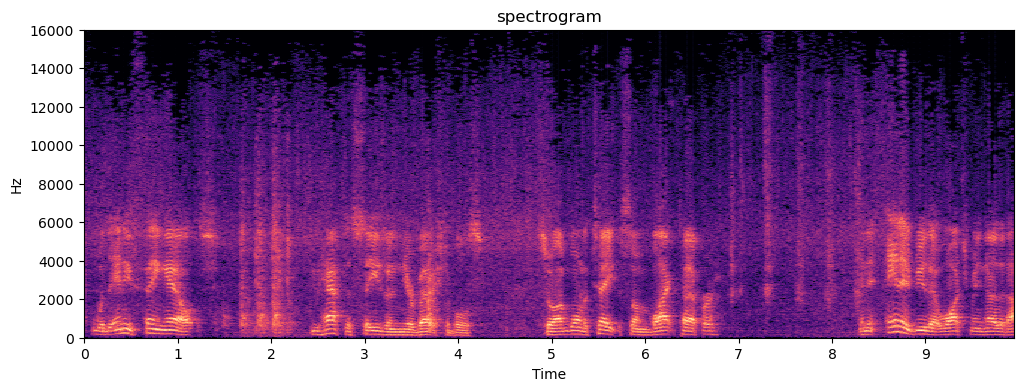

In [22]:
D = submitted.stft(vtln_wave)
display_spectrogram(D, 32000)

In [23]:
vtln_wave = submitted.freq_stretch_griffin_lim(np.abs(spec), stretch_factor=0.75, n_iter=100, hop_size=512)
IPython.display.Audio(vtln_wave, rate=samplerate)

(622, 1025)
(622, 1025)
(622, 1025)


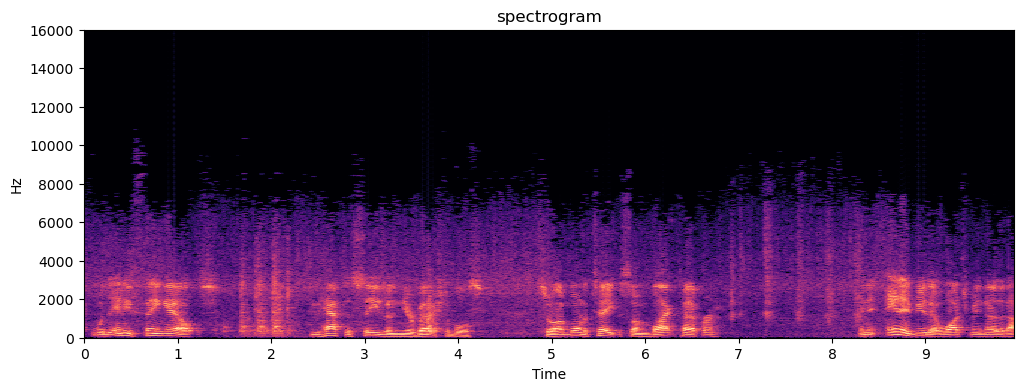

In [24]:
D = submitted.stft(vtln_wave)
display_spectrogram(D, 32000)

As  you can see, this file contains a lot of objects. These are named more or less as in the Jupyter Notebook above, so you can look at each object in detail to figure out why your code is different from the solution.